In [3]:
# Celda 1: lectura robusta de CSV (ignora líneas que empiezan con '#', detecta delimitador)
import csv, io
import pandas as pd
from pathlib import Path

def read_table_robust(path, n_sample_lines=2000):
    """
    Lee un CSV/TSV del tipo NASA que puede tener líneas de metadatos que comienzan con '#'.
    - Detecta el primer encabezado no comentado.
    - Determina el delimitador a partir de las primeras líneas útiles.
    - Usa engine='python' como fallback si la lectura con C falla.
    """
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(path)
    # Leer todas las primeras líneas (memoria OK para archivos razonables)
    with p.open("r", encoding="utf-8", errors="replace") as f:
        lines = f.readlines()

    # encontrar primer índice de línea que NO empiece por '#' y que no esté vacía
    first_idx = None
    for i, L in enumerate(lines):
        if L.strip() and not L.lstrip().startswith("#"):
            first_idx = i
            break
    if first_idx is None:
        # archivo sin líneas útiles
        raise ValueError(f"No se encontró ninguna línea no-comentada en {p}")

    # preparar muestra para sniff (líneas no comentadas a partir del header)
    sample_lines = []
    for L in lines[first_idx:first_idx + 100]:
        if L.strip() and not L.lstrip().startswith("#"):
            sample_lines.append(L)
    sample = "".join(sample_lines) if sample_lines else "".join(lines[first_idx:first_idx+10])

    # intentar detectar delimitador con csv.Sniffer (en muestra sin comentarios)
    try:
        dialect = csv.Sniffer().sniff(sample)
        sep = dialect.delimiter
    except Exception:
        # fallback common separators
        for sep_try in [",", "\t", ";", "|"]:
            if sep_try in sample:
                sep = sep_try
                break
        else:
            sep = ","  # última opción

    # contar cuántas líneas iniciales comentar (para skiprows)
    skiprows = sum(1 for L in lines[:first_idx] if L.lstrip().startswith("#"))

    # Intentar leer con pandas; preferir engine C con comment='#' si es seguro
    try:
        df = pd.read_csv(p, sep=sep, skiprows=skiprows, engine="c", comment="#", low_memory=False)
    except Exception as e_c:
        # intento más tolerante con engine python (acepta campos con distinto número)
        try:
            df = pd.read_csv(p, sep=sep, skiprows=skiprows, engine="python", comment="#", low_memory=False, on_bad_lines="warn")
        except Exception as e_p:
            raise RuntimeError(f"Falló lectura de {p} con sep='{sep}'. Errores: C={e_c} | py={e_p}")
    # devolver df + info del separador detectado para diagnóstico
    return df, sep, skiprows

# Rutas (ajusta si tus ficheros están en otra carpeta)
koi_path = "/home/luna/Desktop/AWorldAwayLuna/Data/cumulative_2025.10.01_11.42.42.csv"
k2_path  = "/home/luna/Desktop/AWorldAwayLuna/Data/k2pandc_2025.10.01_11.47.26.csv"
toi_path = "/home/luna/Desktop/AWorldAwayLuna/Data/TOI_2025.10.01_11.43.58.csv"

# Lee los 3 archivos (imprime el delimitador detectado)
koi, sep_koi, skip_koi = read_table_robust(koi_path)
print(f"[KOI] leído {koi.shape}  (sep='{sep_koi}', skiprows={skip_koi})")

k2, sep_k2, skip_k2 = read_table_robust(k2_path)
print(f"[K2]  leído {k2.shape}  (sep='{sep_k2}', skiprows={skip_k2})")

toi, sep_toi, skip_toi = read_table_robust(toi_path)
print(f"[TOI] leído {toi.shape}  (sep='{sep_toi}', skiprows={skip_toi})")

[KOI] leído (9564, 141)  (sep=',', skiprows=146)
[K2]  leído (4004, 295)  (sep=',', skiprows=300)
[TOI] leído (7699, 87)  (sep=',', skiprows=92)


In [7]:
# Celda 2: mapeos flexibles (nombres que podrían aparecer en cada csv original)
# Usamos los nombres que ya conocemos / usamos en armonización.

maps = {
    "KOI": {
        "orbital_period_days": ["koi_period", "koi_period_days", "period"],
        "transit_duration_hours": ["koi_duration", "koi_duration_hours", "koi_trandur", "tran_duration"],
        "transit_depth_ppm": ["koi_depth", "koi_depth_ppm", "koi_trandep", "depth"],
        "planet_radius_earth": ["koi_prad", "koi_prad_rade", "koi_radius"],
        "equilibrium_temperature_K": ["koi_teq", "koi_eqt"],
        "insolation_flux_Earth": ["koi_insol", "koi_insolation"],
        "stellar_radius_solar": ["koi_srad", "koi_star_radius", "st_rad"],
        "stellar_temperature_K": ["koi_steff", "koi_teff", "st_teff"]
    },
    "K2": {
        "orbital_period_days": ["pl_orbper", "orbital_period_days", "period"],
        "transit_duration_hours": ["pl_trandur", "pl_trandurh", "pl_duration"],
        "transit_depth_ppm": ["pl_trandep", "pl_trandep_ppm", "tran_depth"],
        "planet_radius_earth": ["pl_rade", "pl_radj", "pl_prad"],
        "equilibrium_temperature_K": ["pl_eqt", "pl_teq"],
        "insolation_flux_Earth": ["pl_insol", "pl_insolation"],
        "stellar_radius_solar": ["st_rad", "st_radius"],
        "stellar_temperature_K": ["st_teff", "st_temperature"]
    },
    "TOI": {
        "orbital_period_days": ["pl_orbper", "period"],
        "transit_duration_hours": ["pl_trandurh", "pl_trandur", "tran_duration"],
        "transit_depth_ppm": ["pl_trandep", "tran_depth", "depth"],
        "planet_radius_earth": ["pl_rade", "pl_radj", "pl_prad"],
        "equilibrium_temperature_K": ["pl_eqt", "pl_teq"],
        "insolation_flux_Earth": ["pl_insol", "pl_insolation"],
        "stellar_radius_solar": ["st_rad", "st_radius"],
        "stellar_temperature_K": ["st_teff", "st_temperature"]
    }
}

# helper: buscar el primer nombre existente en df.columns
def pick_col_from_list(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

In [5]:
# Celda 3: normalizador y función que devuelve min, max, n_negativos, n_nulos
import numpy as np

def to_numeric_force(s):
    """Forzar a float, tratando separadores de miles y '%' si aparecen."""
    if s is None:
        return s
    ser = s.copy() if hasattr(s, "copy") else pd.Series(s)
    # Si ya es numérico:
    if pd.api.types.is_numeric_dtype(ser):
        return pd.to_numeric(ser, errors="coerce")
    ser = ser.astype(str).str.strip().str.replace(",", "").str.replace("%", "")
    res = pd.to_numeric(ser.replace({"": np.nan, "NA": np.nan, "nan": np.nan}), errors="coerce")
    return res

def summary_min_max(df, col):
    """Devuelve diccionario con min, max, n_negativos, n_nulls, count."""
    s = to_numeric_force(df[col]) if col in df.columns else pd.Series(dtype="float64")
    if s.size == 0:
        return {"col": col, "present": False}
    mn = float(s.min()) if s.notna().any() else None
    mx = float(s.max()) if s.notna().any() else None
    n_neg = int((s < 0).sum()) if s.notna().any() else 0
    n_null = int(s.isna().sum())
    cnt = int(s.size)
    return {"col": col, "present": True, "min": mn, "max": mx, "n_negative": n_neg, "n_null": n_null, "count": cnt}

In [6]:
# Celda 4: generar tablas summary para KOI, K2, TOI
datasets = [("KOI", koi), ("K2", k2), ("TOI", toi)]
harmon_vars = [
    "orbital_period_days", "transit_duration_hours", "transit_depth_ppm",
    "planet_radius_earth", "equilibrium_temperature_K", "insolation_flux_Earth",
    "stellar_radius_solar", "stellar_temperature_K"
]

results = {}
for name, df in datasets:
    results[name] = []
    M = maps[name]
    print(f"\n=== Resumen para {name} (filas={df.shape[0]}) ===")
    for hv in harmon_vars:
        original_col = pick_col_from_list(df, M.get(hv, []))
        if original_col is None:
            # no existe columna equivalente
            print(f"{hv:30s}  -> MISSING in {name}")
            results[name].append({"harmon_var": hv, "original_col": None, **{"present": False}})
        else:
            info = summary_min_max(df, original_col)
            info["harmon_var"] = hv
            info["original_col"] = original_col
            results[name].append(info)
            # imprimir resumen claro
            print(f"{hv:30s} ({original_col:20s})  min = {info.get('min')} , max = {info.get('max')} , neg = {info.get('n_negative')} , nulls = {info.get('n_null')}")


=== Resumen para KOI (filas=9564) ===
orbital_period_days            (koi_period          )  min = 0.241842544 , max = 129995.7784 , neg = 0 , nulls = 0
transit_duration_hours         (koi_duration        )  min = 0.052 , max = 138.54 , neg = 0 , nulls = 0
transit_depth_ppm              (koi_depth           )  min = 0.0 , max = 1541400.0 , neg = 0 , nulls = 363
planet_radius_earth            (koi_prad            )  min = 0.08 , max = 200346.0 , neg = 0 , nulls = 363
equilibrium_temperature_K      (koi_teq             )  min = 25.0 , max = 14667.0 , neg = 0 , nulls = 363
insolation_flux_Earth          (koi_insol           )  min = 0.0 , max = 10947554.55 , neg = 0 , nulls = 321
stellar_radius_solar           (koi_srad            )  min = 0.109 , max = 229.908 , neg = 0 , nulls = 363
stellar_temperature_K          (koi_steff           )  min = 2661.0 , max = 15896.0 , neg = 0 , nulls = 363

=== Resumen para K2 (filas=4004) ===
orbital_period_days            (pl_orbper           )  min =

Juntemos las bases de datos!

In [8]:
import os
import pandas as pd
from pathlib import Path

# === CONFIGURACIÓN DE RUTAS ===
base_path = Path("/home/luna/Desktop/AWorldAwayLuna/Data")
output_dir = Path("/home/luna/Desktop/AWorldAwayLuna/DATA")
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / "DatosJuntados.csv"

# Archivos originales
koi_path = base_path / "cumulative_2025.10.01_11.42.42.csv"
k2_path  = base_path / "k2pandc_2025.10.01_11.47.26.csv"
toi_path = base_path / "TOI_2025.10.01_11.43.58.csv"

# === LECTURA FLEXIBLE ===
def read_nasa_csv(path):
    try:
        return pd.read_csv(path, comment="#", low_memory=False)
    except Exception:
        return pd.read_csv(path, comment="#", sep="\t", low_memory=False)

koi = read_nasa_csv(koi_path)
k2  = read_nasa_csv(k2_path)
toi = read_nasa_csv(toi_path)

print(f"KOI: {koi.shape}, K2: {k2.shape}, TOI: {toi.shape}")

# === COLUMNAS DE INTERÉS (ARMONIZADAS, SIN transit_depth_ppm) ===
# Usamos equivalencias conocidas entre misiones.
column_map = {
    "KOI": {
        "orbital_period_days": "koi_period",
        "transit_duration_hours": "koi_duration",
        "planet_radius_earth": "koi_prad",
        "equilibrium_temperature_K": "koi_teq",
        "insolation_flux_Earth": "koi_insol",
        "stellar_radius_solar": "koi_srad",
        "stellar_temperature_K": "koi_steff",
        "final_disposition": "koi_disposition"
    },
    "K2": {
        "orbital_period_days": "pl_orbper",
        "transit_duration_hours": "pl_trandur",
        "planet_radius_earth": "pl_rade",
        "equilibrium_temperature_K": "pl_eqt",
        "insolation_flux_Earth": "pl_insol",
        "stellar_radius_solar": "st_rad",
        "stellar_temperature_K": "st_teff",
        "final_disposition": "disposition"
    },
    "TOI": {
        "orbital_period_days": "pl_orbper",
        "transit_duration_hours": "pl_trandurh",
        "planet_radius_earth": "pl_rade",
        "equilibrium_temperature_K": "pl_eqt",
        "insolation_flux_Earth": "pl_insol",
        "stellar_radius_solar": "st_rad",
        "stellar_temperature_K": "st_teff",
        "final_disposition": "disposition"
    }
}

# === SELECCIONAR Y RENOMBRAR ===
def select_and_rename(df, mapping, mission):
    subset = {}
    for unified, original in mapping.items():
        if original in df.columns:
            subset[unified] = df[original]
        else:
            subset[unified] = pd.Series([None] * len(df))
    out = pd.DataFrame(subset)
    out["source_mission"] = mission
    return out

koi_sel = select_and_rename(koi, column_map["KOI"], "KEPLER")
k2_sel  = select_and_rename(k2,  column_map["K2"],  "K2")
toi_sel = select_and_rename(toi, column_map["TOI"], "TESS")

# === CONCATENAR ===
combined = pd.concat([koi_sel, k2_sel, toi_sel], ignore_index=True)
print("🔹 Dataset combinado:", combined.shape)

# === GUARDAR ===
combined.to_csv(output_path, index=False)
print(f"✅ Archivo guardado en: {output_path}")

# Mostrar un vistazo
combined.head()

KOI: (9564, 141), K2: (4004, 295), TOI: (7699, 87)
🔹 Dataset combinado: (21267, 9)
✅ Archivo guardado en: /home/luna/Desktop/AWorldAwayLuna/DATA/DatosJuntados.csv


,orbital_period_days,transit_duration_hours,planet_radius_earth,equilibrium_temperature_K,insolation_flux_Earth,stellar_radius_solar,stellar_temperature_K,final_disposition,source_mission
0,9.488036,2.95750,2.26,793.0,93.59,0.927,5455.0,CONFIRMED,KEPLER
1,54.418383,4.50700,2.83,443.0,9.11,0.927,5455.0,CONFIRMED,KEPLER
2,19.899140,1.78220,14.60,638.0,39.30,0.868,5853.0,CANDIDATE,KEPLER
3,1.736952,2.40641,33.46,1395.0,891.96,0.791,5805.0,FALSE POSITIVE,KEPLER
4,2.525592,1.65450,2.75,1406.0,926.16,1.046,6031.0,CONFIRMED,KEPLER


In [10]:
print(df.columns.tolist())

['orbital_period_days', 'transit_duration_hours', 'planet_radius_earth', 'equilibrium_temperature_K', 'insolation_flux_Earth', 'stellar_radius_solar', 'stellar_temperature_K', 'final_disposition', 'source_mission']


In [11]:
df.head(3)

,orbital_period_days,transit_duration_hours,planet_radius_earth,equilibrium_temperature_K,insolation_flux_Earth,stellar_radius_solar,stellar_temperature_K,final_disposition,source_mission
0,9.488036,2.9575,2.26,793.0,93.59,0.927,5455.0,CONFIRMED,KEPLER
1,54.418383,4.5070,2.83,443.0,9.11,0.927,5455.0,CONFIRMED,KEPLER
2,19.899140,1.7822,14.60,638.0,39.30,0.868,5853.0,CANDIDATE,KEPLER


In [12]:
import pandas as pd

# Ruta del dataset
df = pd.read_csv("/home/luna/Desktop/AWorldAwayLuna/DATA/DatosJuntados.csv")

# Mostrar los valores únicos de final_disposition (sin filtrar nulos)
print("=== Valores únicos de 'final_disposition' ===")
print(df['final_disposition'].unique())

# Contar cuántas veces aparece cada valor (para revisar distribuciones)
print("\n=== Frecuencia de cada valor ===")
print(df['final_disposition'].value_counts(dropna=False))

=== Valores únicos de 'final_disposition' ===
['CONFIRMED' 'CANDIDATE' 'FALSE POSITIVE' 'REFUTED' nan]

=== Frecuencia de cada valor ===
final_disposition
NaN               7699
FALSE POSITIVE    5132
CONFIRMED         5061
CANDIDATE         3353
REFUTED             22
Name: count, dtype: int64


In [13]:
# Filtrar las filas sin disposición
missing_disp = df[df['final_disposition'].isna()]

# Contar por misión
print(missing_disp['source_mission'].value_counts(dropna=False))

source_mission
TESS    7699
Name: count, dtype: int64


Ahora sí, apliquemos imputaciones a los datos nulos.

In [9]:
# Los datos nulos:
import pandas as pd

# Cargar el dataset recién creado
path = "/home/luna/Desktop/AWorldAwayLuna/DATA/DatosJuntados.csv"
df = pd.read_csv(path)

# Calcular nulos absolutos y porcentuales
nulls_abs = df.isna().sum()
nulls_pct = (df.isna().mean() * 100).round(2)

# Mostrar resumen ordenado
nulos_df = pd.DataFrame({
    "Nulos": nulls_abs,
    "% Nulos": nulls_pct
}).sort_values("% Nulos", ascending=False)

print("=== Porcentaje de nulos por columna ===")
display(nulos_df)

=== Porcentaje de nulos por columna ===


,Nulos,% Nulos
final_disposition,7699,36.20
insolation_flux_Earth,3872,18.21
equilibrium_temperature_K,3833,18.02
planet_radius_earth,1714,8.06
stellar_temperature_K,1651,7.76
transit_duration_hours,1237,5.82
stellar_radius_solar,1018,4.79
orbital_period_days,174,0.82
source_mission,0,0.00


Esto a continuación construyó un dataset de 2 columnas, ignorando las numéricas, no debía hacerlo xD fue un error, pero bueno.

In [16]:
import pandas as pd
from pathlib import Path

# === Rutas ===
base_dir = Path("/home/luna/Desktop/AWorldAwayLuna/Data")
files = {
    "KEPLER": base_dir / "cumulative_2025.10.01_11.42.42.csv",
    "K2": base_dir / "k2pandc_2025.10.01_11.47.26.csv",
    "TESS": base_dir / "TOI_2025.10.01_11.43.58.csv"
}

def load_best_csv(path):
    """Detecta el mejor separador probando varios y elige el que más columnas produce."""
    seps = [',', ';', '\t', '|', '#']
    best_df, best_sep, best_cols = None, None, 0
    for s in seps:
        try:
            df = pd.read_csv(path, sep=s, comment='#', low_memory=False)
            if df.shape[1] > best_cols:
                best_df, best_sep, best_cols = df, s, df.shape[1]
        except Exception:
            continue
    if best_df is not None:
        print(f"✅ {path.name} leído correctamente con separador '{best_sep}' ({best_cols} columnas).")
        return best_df
    else:
        print(f"❌ No se pudo leer {path.name} con ningún separador.")
        return pd.DataFrame()

# === Cargar datasets ===
datasets = {name: load_best_csv(path) for name, path in files.items()}

# === Reconstruir final_disposition según dataset ===
if "koi_disposition" in datasets["KEPLER"].columns:
    datasets["KEPLER"]["final_disposition"] = datasets["KEPLER"]["koi_disposition"]
if "disposition" in datasets["K2"].columns:
    datasets["K2"]["final_disposition"] = datasets["K2"]["disposition"]
if "tfopwg_disp" in datasets["TESS"].columns:
    datasets["TESS"]["final_disposition"] = datasets["TESS"]["tfopwg_disp"]

# === Añadir columna de origen ===
for name, df in datasets.items():
    df["source_mission"] = name

# === Seleccionar columnas comunes ===
common_cols = [
    "orbital_period_days",
    "transit_duration_hours",
    "planet_radius_earth",
    "equilibrium_temperature_K",
    "insolation_flux_Earth",
    "stellar_radius_solar",
    "stellar_temperature_K",
    "final_disposition",
    "source_mission",
]

def safe_select(df, cols):
    return df[[c for c in cols if c in df.columns]].copy()

selected = [safe_select(df, common_cols) for df in datasets.values()]

# === Unir datasets ===
merged = pd.concat(selected, ignore_index=True)

# === Guardar ===
out_dir = Path("/home/luna/Desktop/AWorldAwayLuna/DATA")
out_dir.mkdir(exist_ok=True)
out_path = out_dir / "DatosJuntados_Reconstruido.csv"
merged.to_csv(out_path, index=False)

print(f"\n✅ Dataset fusionado guardado en: {out_path}")
print("\n=== Tamaño final ===")
print(merged.shape)
print("\n=== Valores únicos de 'final_disposition' ===")
print(merged["final_disposition"].value_counts(dropna=False))

✅ cumulative_2025.10.01_11.42.42.csv leído correctamente con separador ',' (141 columnas).
✅ k2pandc_2025.10.01_11.47.26.csv leído correctamente con separador ',' (295 columnas).
✅ TOI_2025.10.01_11.43.58.csv leído correctamente con separador ',' (87 columnas).

✅ Dataset fusionado guardado en: /home/luna/Desktop/AWorldAwayLuna/DATA/DatosJuntados_Reconstruido.csv

=== Tamaño final ===
(21267, 2)

=== Valores únicos de 'final_disposition' ===
final_disposition
FALSE POSITIVE    5132
CONFIRMED         5061
PC                4678
CANDIDATE         3353
FP                1196
CP                 683
KP                 583
APC                461
FA                  98
REFUTED             22
Name: count, dtype: int64


A continuación, voy a analizar los datos de DATA que fueron filtrados por Michael.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Ruta del dataset
path = Path("/home/luna/Desktop/AWorldAwayLuna/DATA/data.csv")

# Leer CSV
df = pd.read_csv(path, low_memory=False)
print(f"✅ Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]:,} columnas\n")

# Mostrar primeras filas y tipos de datos
display(df.head())
print("\n=== Tipos de datos ===")
print(df.dtypes)

✅ Dataset cargado: 21,245 filas × 10 columnas



,orbital_period_days,transit_duration_hours,transit_depth_ppm,planet_radius_earth,equilibrium_temperature_K,insolation_flux_Earth,stellar_radius_solar,stellar_temperature_K,final_disposition,source_mission
0,9.488036,2.95750,615.8,2.26,793.0,93.59,0.927,5455.0,CONFIRMED,KEPLER
1,54.418383,4.50700,874.8,2.83,443.0,9.11,0.927,5455.0,CONFIRMED,KEPLER
2,19.899140,1.78220,10829.0,14.60,638.0,39.30,0.868,5853.0,CANDIDATE,KEPLER
3,1.736952,2.40641,8079.2,33.46,1395.0,891.96,0.791,5805.0,FALSE_POSITIVE,KEPLER
4,2.525592,1.65450,603.3,2.75,1406.0,926.16,1.046,6031.0,CONFIRMED,KEPLER



=== Tipos de datos ===
orbital_period_days          float64
transit_duration_hours       float64
transit_depth_ppm            float64
planet_radius_earth          float64
equilibrium_temperature_K    float64
insolation_flux_Earth        float64
stellar_radius_solar         float64
stellar_temperature_K        float64
final_disposition             object
source_mission                object
dtype: object


,Nulos,% Nulos
orbital_period_days,0,0.0
transit_duration_hours,0,0.0
transit_depth_ppm,0,0.0
planet_radius_earth,0,0.0
equilibrium_temperature_K,0,0.0
insolation_flux_Earth,0,0.0
stellar_radius_solar,0,0.0
stellar_temperature_K,0,0.0
final_disposition,0,0.0
source_mission,0,0.0


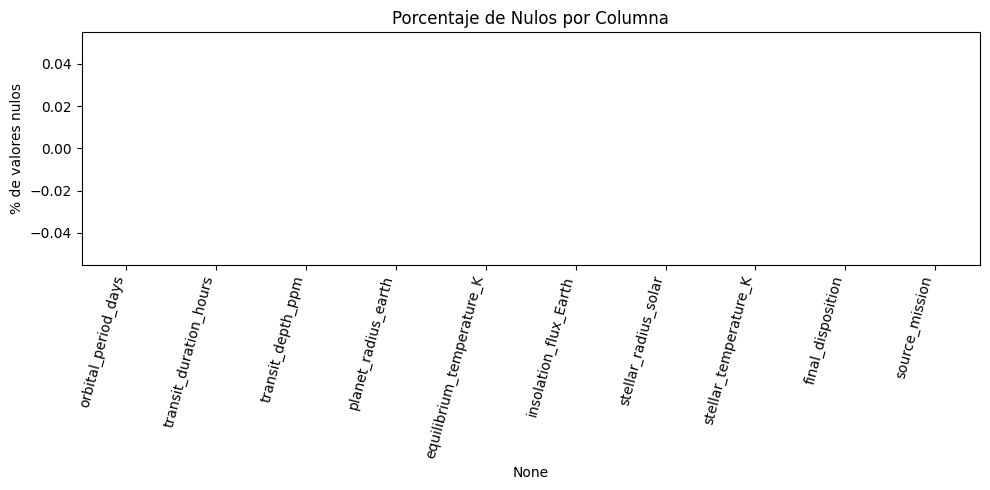

In [18]:
# Conteo y porcentaje de valores nulos
nulos = df.isna().sum().sort_values(ascending=False)
porc_nulos = (df.isna().mean() * 100).sort_values(ascending=False)

nulos_df = pd.DataFrame({
    "Nulos": nulos,
    "% Nulos": porc_nulos.round(2)
})
display(nulos_df)

# Gráfico de nulos
plt.figure(figsize=(10,5))
sns.barplot(x=nulos_df.index, y=nulos_df["% Nulos"])
plt.xticks(rotation=75, ha='right')
plt.title("Porcentaje de Nulos por Columna")
plt.ylabel("% de valores nulos")
plt.tight_layout()
plt.show()


In [19]:
# Detectar columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("=== Columnas categóricas detectadas ===")
print(cat_cols)

for col in cat_cols:
    print(f"\n→ {col}:")
    print(df[col].value_counts(dropna=False))

=== Columnas categóricas detectadas ===
['final_disposition', 'source_mission']

→ final_disposition:
final_disposition
CANDIDATE         8492
FALSE_POSITIVE    6426
CONFIRMED         6327
Name: count, dtype: int64

→ source_mission:
source_mission
KEPLER    9564
TESS      7699
K2        3982
Name: count, dtype: int64


Variables numéricas (8): ['orbital_period_days', 'transit_duration_hours', 'transit_depth_ppm', 'planet_radius_earth', 'equilibrium_temperature_K', 'insolation_flux_Earth', 'stellar_radius_solar', 'stellar_temperature_K']


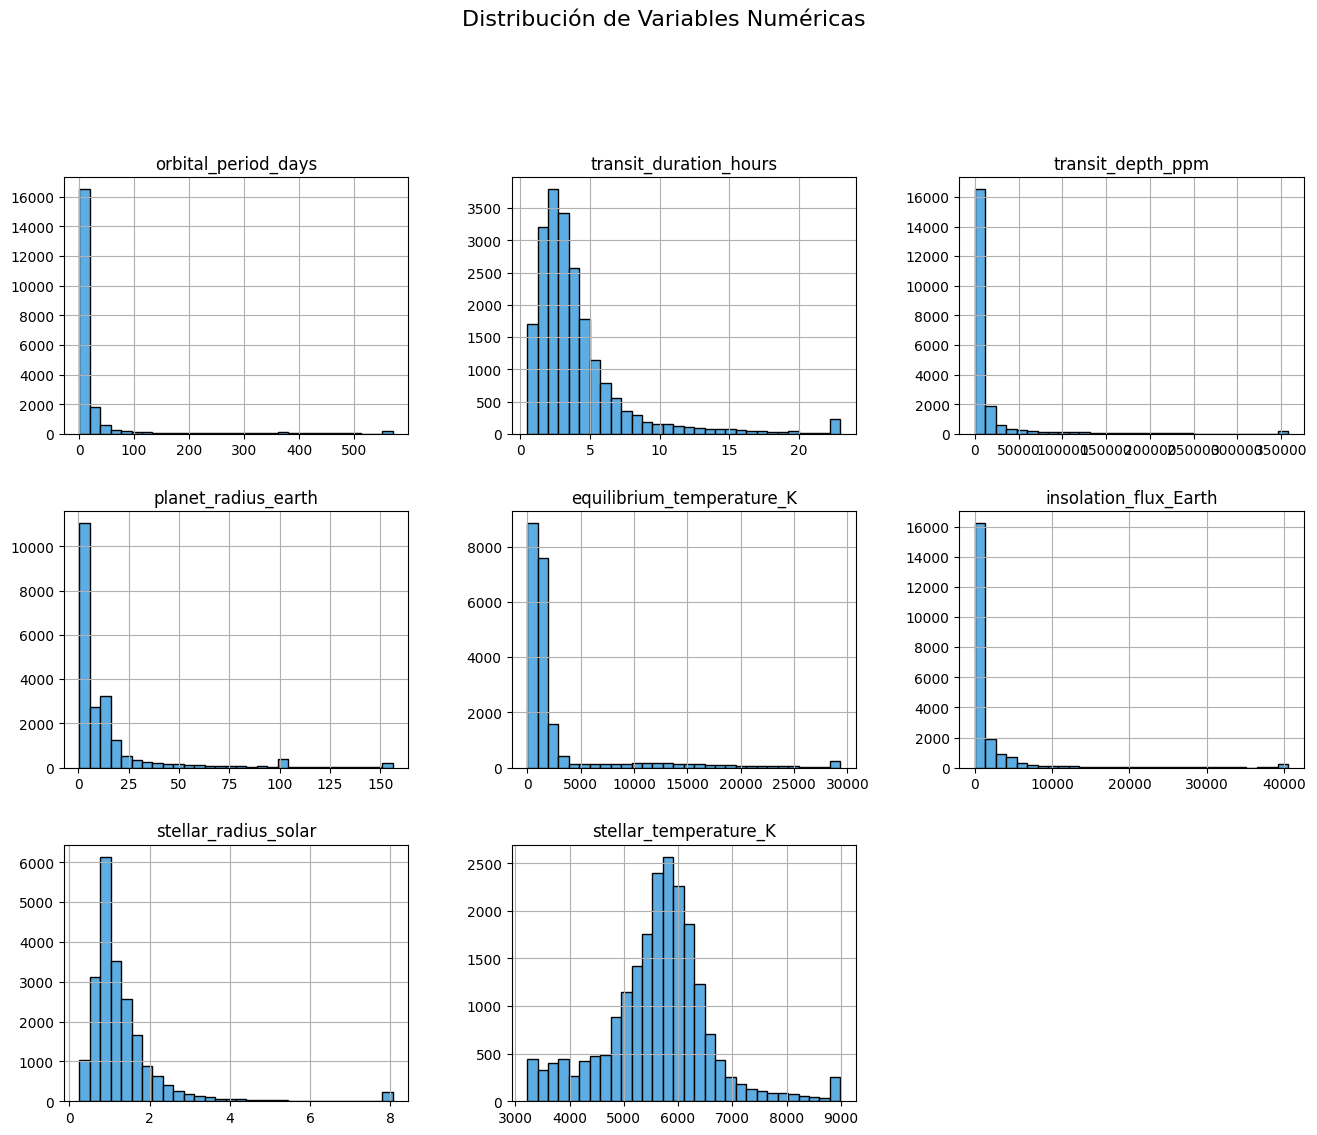

In [20]:
# Detectar columnas numéricas
num_cols = df.select_dtypes(include=['number']).columns.tolist()
print(f"Variables numéricas ({len(num_cols)}): {num_cols}")

# Histogramas
df[num_cols].hist(bins=30, figsize=(16, 12), color="#5DADE2", edgecolor="black")
plt.suptitle("Distribución de Variables Numéricas", fontsize=16, y=1.02)
plt.show()

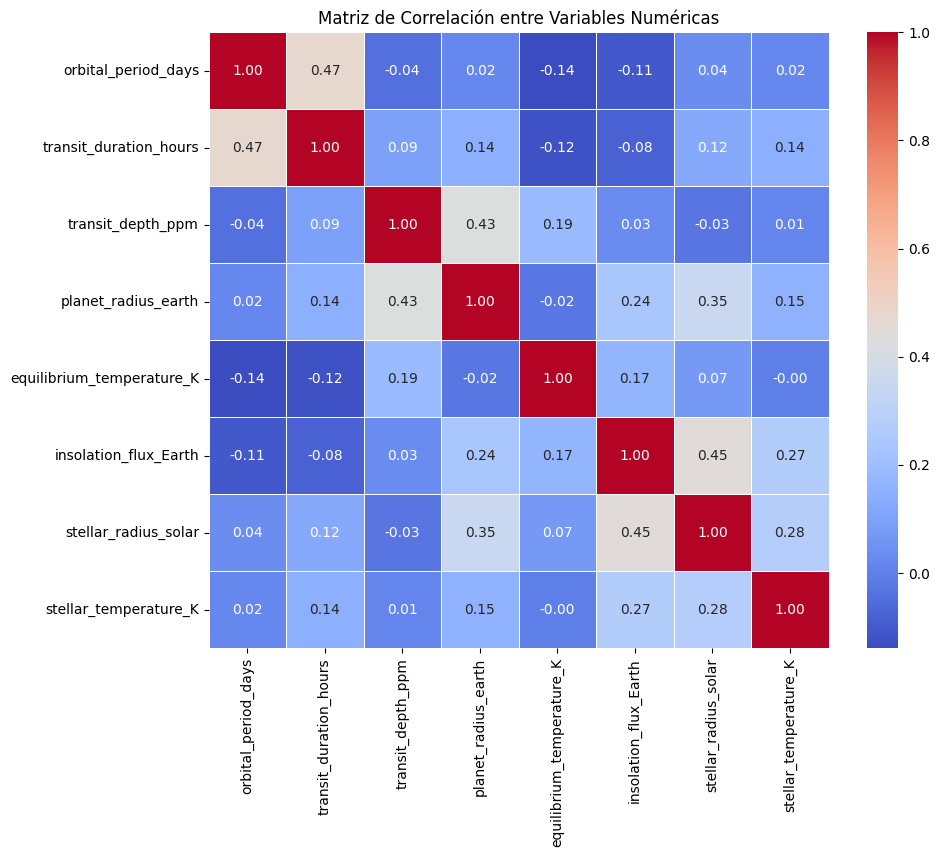

In [21]:
plt.figure(figsize=(10, 8))
corr = df[num_cols].corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()

In [22]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
orbital_period_days,21245.0,36.692391,96.908564,0.451837,2.635737,5.890356,16.736476,569.981581
transit_duration_hours,21245.0,4.130615,3.650273,0.485303,2.068883,3.145000,4.710000,22.989576
transit_depth_ppm,21245.0,18696.932404,53533.172882,0.000000,327.600000,1400.000000,9913.000000,357953.200000
planet_radius_earth,21245.0,14.351400,25.620718,0.590000,2.000000,5.036060,13.960000,156.000400
equilibrium_temperature_K,21245.0,2924.569732,5343.367563,0.000000,695.129031,1125.000000,1827.000000,29339.390442
insolation_flux_Earth,21245.0,1869.387698,5373.491733,0.000000,34.940000,233.780000,1203.770000,40519.208836
stellar_radius_solar,21245.0,1.335096,1.046318,0.250000,0.820000,1.050000,1.500000,8.055360
stellar_temperature_K,21245.0,5620.199233,979.255420,3217.520000,5144.900000,5700.000000,6122.000000,8991.560000


In [23]:
import pandas as pd

# --- Variables numéricas ---
num_cols = df.select_dtypes(include=['number']).columns.tolist()

print("=== Intervalos de variables numéricas ===")
for col in num_cols:
    col_min = df[col].min(skipna=True)
    col_max = df[col].max(skipna=True)
    print(f"{col}: min = {col_min}, max = {col_max}")

# --- Variables categóricas ---
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("\n=== Variables categóricas (valores únicos y frecuencias) ===")
for col in cat_cols:
    print(f"\n→ {col}: valores únicos = {df[col].dropna().unique()}")
    print(df[col].value_counts(dropna=False))


=== Intervalos de variables numéricas ===
orbital_period_days: min = 0.4518373720000007, max = 569.9815810000001
transit_duration_hours: min = 0.4853028172653019, max = 22.98957577832262
transit_depth_ppm: min = 0.0, max = 357953.2000000003
planet_radius_earth: min = 0.59, max = 156.00040000000044
equilibrium_temperature_K: min = 0.0, max = 29339.3904417822
insolation_flux_Earth: min = 0.0, max = 40519.208836177786
stellar_radius_solar: min = 0.25, max = 8.055360000000007
stellar_temperature_K: min = 3217.52, max = 8991.560000000001

=== Variables categóricas (valores únicos y frecuencias) ===

→ final_disposition: valores únicos = ['CONFIRMED' 'CANDIDATE' 'FALSE_POSITIVE']
final_disposition
CANDIDATE         8492
FALSE_POSITIVE    6426
CONFIRMED         6327
Name: count, dtype: int64

→ source_mission: valores únicos = ['KEPLER' 'K2' 'TESS']
source_mission
KEPLER    9564
TESS      7699
K2        3982
Name: count, dtype: int64
